In [84]:
import pandas as pd
import numpy as np
import random

In [85]:
users = pd.DataFrame(
    columns=[
        "id",
        "createdAt",
        "birthDate",
        "age",
        "ageGroup",
        "address",
        "city",
        "state",
        "country",
        "lastLogin",
        "firstAccountType",
        "daysFromLastLogin",
    ]
)

accounts = pd.DataFrame(
    columns=[
        "id",
        "userId",
        "createdAt",
        "accountType",
        "balance",
        "status",
        "lastActivityDate",
        "lastTransferDate",
    ]
)

transfers = pd.DataFrame(
    columns=[
        "id",
        "amount",
        "date",
        "createdAt",
        "isScheduled",
        "status",
        "fromId",
        "toId",
    ]
)

# Mocando dados

In [86]:
from datetime import datetime, timedelta
from scipy.stats import skewnorm
from matplotlib import pyplot as plt

rng = np.random.default_rng(30)

USER_COUNT = 10000
ACCOUNT_COUNT = 25000
TRANSFER_COUNT = 40000

## users

### id

In [87]:
users['id'] = range(0, USER_COUNT)
users.set_index('id', inplace=True)
users.index.name = None

### address

In [88]:
cidades_brasil = pd.read_csv(
    "./ibge_cidades.csv",
    sep=",",
    encoding="utf-8",
)

cidades_brasil.head()

cidades_brasil.drop(
    columns=["ConcatUF+Mun", "IBGE", "IBGE7", "Unnamed: 9"], inplace=True
)

cidades_brasil = cidades_brasil[cidades_brasil["População 2010"].isnull() == False]

populacao_total = cidades_brasil["População 2010"].sum()
cidades_brasil["Porcentagem da População"] = (
    cidades_brasil["População 2010"] / populacao_total
)

In [89]:
weights = cidades_brasil["Porcentagem da População"].values
weights = weights / np.sum(weights)
cidades_brasil["weights"] = weights
cidades_brasil["weights"] = cidades_brasil["weights"].apply(lambda x: float(x))

In [90]:
city_state = rng.choice(cidades_brasil[['Município', 'UF']], size=USER_COUNT, p=cidades_brasil['weights'].values)
city_state = pd.DataFrame(city_state, columns=['city', 'state'])

In [91]:
users['state'] = city_state['state']
users['city'] = city_state['city']
users['address'] = users['city'] + ', ' + users['state'] + ', Brasil'
users['country'] = 'Brasil'

### createdAt

Dias após o lançamento do App para implementação da feature de múltiplas contas:  596
Data de implementação da feature de múltiplas contas:  2023-08-20 00:00:00


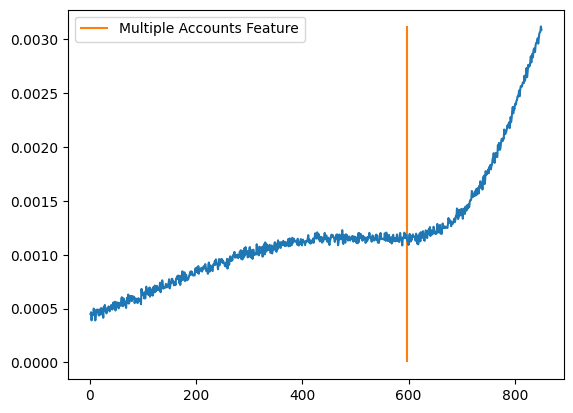

In [92]:
# Lançamento do App - 01/01/2022
# Última coleta de dados sobre o App - 30/04/2024
start = pd.to_datetime("2022-01-01")
end = pd.to_datetime("2024-04-30")

# Gerando range de dias
min_value = 1
max_value = end - start
max_value = max_value.days
lin_range = np.linspace(0, 1, max_value - min_value + 1)

# Gerando pesos
a1 = 1
loc1 = 0.3
scale1 = 0.5
a2 = -1
loc2 = 1.2
scale2 = 0.17

# Gerando as distribuições de pesos
weights1 = skewnorm.pdf(x=lin_range,
                        a=a1,
                        loc=loc1,
                        scale=scale1)
weights2 = skewnorm.pdf(x=lin_range,
                        a=a2,
                        loc=loc2,
                        scale=scale2)
weights = weights1 + weights2

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.025, size=max_value - min_value + 1))
weights = weights / np.sum(weights)

# Adição da feature múltiplas contas ao app
feature_multiple_accounts = round((max_value + 1) * 0.7)

print('Dias após o lançamento do App para implementação da feature de múltiplas contas: ', feature_multiple_accounts)
print('Data de implementação da feature de múltiplas contas: ', pd.to_datetime('2022-01-01') + pd.to_timedelta(feature_multiple_accounts, unit='d'))

plt.gca().vlines(np.array([feature_multiple_accounts]), ymin=0, ymax=np.max(weights), colors='C1')
plt.legend(['Multiple Accounts Feature'])
plt.plot(np.arange(min_value, max_value + 1), weights)
plt.show()

In [93]:
created_at = rng.choice(np.linspace(1, max_value, max_value - min_value + 1), size=USER_COUNT, p=weights
)
users['createdAt'] = created_at
users['createdAt'] = users['createdAt'].apply(lambda x: start + timedelta(days=x))

### birthdate

Pico de usuários nascidos na faixa de 1998 a 2004


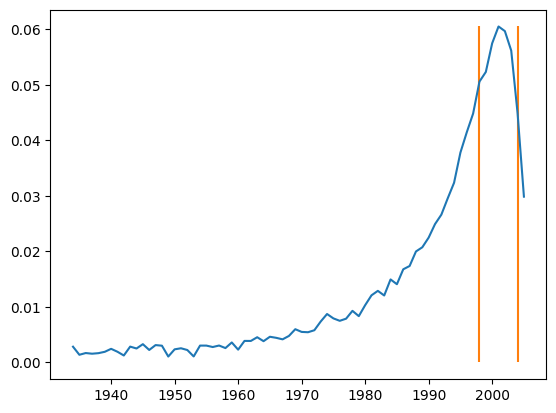

In [94]:
from scipy.stats import alpha

# Gerando range de anos
initial_days = 1934
max_value = 2005
lin_range = np.linspace(0, 1, max_value - initial_days + 1)


# Gerando pesos para os anos
a = 1
loc = -0.1
scale = 0.3
weights = alpha.pdf(x=lin_range, a=a, loc=loc, scale=scale)
weights = np.flip(weights)

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.05, size=max_value - initial_days + 1))
weights = weights / np.sum(weights)

print('Pico de usuários nascidos na faixa de 1998 a 2004')

plt.gca().vlines(np.array([1998, 2004]), ymin=0, ymax=np.max(weights), colors='C1')
plt.plot(np.arange(initial_days, max_value + 1), weights)
plt.show()

In [95]:
def gen_random_date(year):
    day = random.randint(1, 31)
    month = random.randint(1, 12)
    if month == 2 and day > 28:
        day = 28
    if month in [4, 6, 9, 11] and day > 30:
        day = 30
    if month == 2 and day == 29:
        if year % 4 != 0 or (year % 100 == 0 and year % 400 != 0):
            day = 28
    birth_date = pd.Timestamp(
        year=year, month=month, day=day, hour=0, minute=0, second=0
    )
    return birth_date 

In [96]:
users["birthDate"] = rng.choice(
    np.arange(initial_days, max_value + 1), size=USER_COUNT, p=weights
)

users["birthDate"] = users["birthDate"].apply(gen_random_date)

In [97]:
users["age"] = (end - users["birthDate"]).dt.days // 365

In [98]:
age_groups = [
    {"name": "18-24", "min": 18, "max": 24},
    {"name": "25-31", "min": 25, "max": 31},
    {"name": "32-48", "min": 32, "max": 38},
    {"name": "39-45", "min": 39, "max": 45},
    {"name": "46-52", "min": 46, "max": 52},
    {"name": "53-59", "min": 53, "max": 59},
    {"name": "60-66", "min": 60, "max": 66},
    {"name": "67-73", "min": 67, "max": 73},
    {"name": "74-80", "min": 74, "max": 80},
    {"name": "81+", "min": 81, "max": 100},
]

get_age_group = lambda x: [
    group["name"] for group in age_groups if group["min"] <= x <= group["max"]
]

users["ageGroup"] = users["age"].apply(lambda x: get_age_group(x)[0])

### firstAccountType

In [99]:
account_types = ['Conta Corrente', 'Conta Poupança']
users['firstAccountType'] = rng.choice(account_types, size=USER_COUNT, p=[0.67, 0.33])

### lastLoginDate

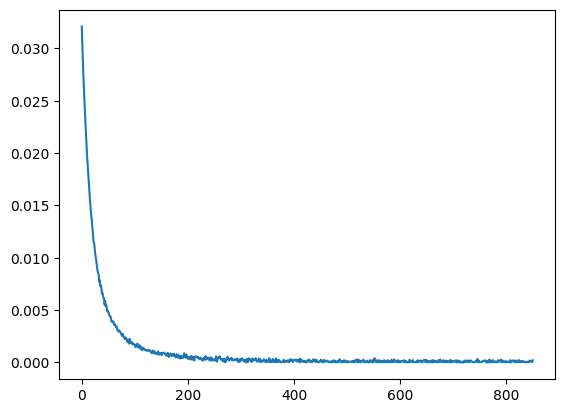

In [100]:
from scipy.stats import alpha

# Gerando range de anos
min_value = 0
max_value = 850
lin_range = np.linspace(0, 1, max_value - min_value + 1)


# Gerando pesos para os anos
a = 1
loc = -0.04
scale = 0.05
weights = alpha.pdf(x=lin_range, a=a, loc=loc, scale=scale)

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.05, size=max_value - min_value + 1))
weights = weights / np.sum(weights)


plt.plot(np.arange(min_value, max_value + 1), weights)
plt.show()

In [101]:
users['daysFromCreation'] = (pd.to_datetime('2024-04-30') - users['createdAt']).dt.days

In [102]:
last_login = rng.choice(
    np.linspace(0, 1, (max_value - min_value + 1)), size=USER_COUNT, p=weights
)

In [103]:
users['daysFromLastLogin'] = round(last_login * users['daysFromCreation']).astype(int)

In [104]:
users['lastLogin'] = pd.to_datetime('2024-04-30') - pd.to_timedelta(users['daysFromLastLogin'], unit='d')

In [105]:
users.describe()

,createdAt,birthDate,age,lastLogin,daysFromLastLogin,daysFromCreation
count,10000,10000,10000.000000,10000,10000.00000,10000.000000
mean,2023-06-05 08:55:40.800000,1990-09-10 04:55:37.919999872,33.162500,2024-03-29 20:18:57.600000,31.15350,329.628000
min,2022-01-02 00:00:00,1934-01-03 00:00:00,18.000000,2022-03-02 00:00:00,0.00000,0.000000
25%,2022-11-25 00:00:00,1985-07-10 06:00:00,23.000000,2024-04-04 00:00:00,2.00000,108.000000
50%,2023-07-04 00:00:00,1995-11-02 00:00:00,28.000000,2024-04-23 00:00:00,7.00000,301.000000
75%,2024-01-13 00:00:00,2000-12-24 00:00:00,38.000000,2024-04-28 00:00:00,26.00000,522.000000
max,2024-04-30 00:00:00,2005-12-31 00:00:00,90.000000,2024-04-30 00:00:00,790.00000,849.000000
std,NaN,NaN,14.772918,NaN,71.77621,239.156027


In [106]:
users.head()

,createdAt,birthDate,age,ageGroup,address,city,state,country,lastLogin,firstAccountType,daysFromLastLogin,daysFromCreation
0,2022-10-26,1995-04-08,29,25-31,"Lajedo, PE, Brasil",Lajedo,PE,Brasil,2024-03-30,Conta Poupança,31,552
1,2023-12-05,1987-08-06,36,32-48,"Novo Cruzeiro, MG, Brasil",Novo Cruzeiro,MG,Brasil,2024-02-05,Conta Poupança,85,147
2,2024-01-21,2003-04-18,21,18-24,"Coelho Neto, MA, Brasil",Coelho Neto,MA,Brasil,2024-04-29,Conta Poupança,1,100
3,2022-10-13,1971-01-25,53,53-59,"Campo Limpo Paulista, SP, Brasil",Campo Limpo Paulista,SP,Brasil,2024-04-11,Conta Poupança,19,565
4,2024-01-10,2001-06-27,22,18-24,"Estiva Gerbi, SP, Brasil",Estiva Gerbi,SP,Brasil,2024-04-28,Conta Corrente,2,111


## accounts

### users with multiple accounts

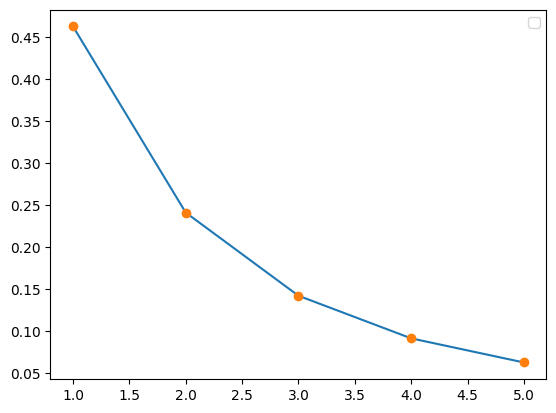

In [107]:
# Gerando range de contas
min_accounts = 1
max_accounts = 5
lin_range = np.linspace(0, 1, max_accounts - min_accounts + 1)

# Gerando pesos
a = 5
loc = -1.5
scale = 0.8

# Gerando as distribuições de pesos
weights = alpha.pdf(x=lin_range,
                        a=a,
                        loc=loc,
                        scale=scale)
weights = weights / np.sum(weights)

plt.legend(['Multiple Accounts Feature'])
plt.plot(np.arange(min_accounts, max_accounts + 1), weights)
plt.plot(np.arange(min_accounts, max_accounts + 1), weights, 'o')
plt.show()

In [108]:
users['accountCount'] = rng.choice(
    np.arange(min_accounts, max_accounts + 1), size=USER_COUNT, p=weights
)
users['accountCount'].value_counts()

accountCount
1    4598
2    2431
3    1416
4     950
5     605
Name: count, dtype: int64

### id

In [109]:
accounts['id'] = range(0, ACCOUNT_COUNT)
accounts.set_index('id', inplace=True)
accounts.index.name = None

### accountType

In [110]:
accounts['status'] = rng.choice(['active', 'blocked', 'inactive'], size=ACCOUNT_COUNT, p=[0.9, 0.06, 0.04])

### usersFirstAccount

In [111]:
first_accounts = accounts.loc[0:USER_COUNT - 1].copy()
first_accounts[['createdAt', 'accountType']] = users[['createdAt', 'firstAccountType']]
first_accounts['userId'] = users.index
accounts.update(first_accounts)

### other accounts

In [112]:
last_index = accounts[accounts['userId'].isnull()].head(1).index[0] - 1
n_accounts = 0
for index, row in users.iterrows():
    for i in range(row['accountCount'] - 1):
        n_accounts += 1
        last_index += 1
        accounts.at[last_index, 'userId'] = index

In [113]:
accounts.groupby('userId').size().value_counts()

1    4598
2    2431
3    1416
4     950
5     605
Name: count, dtype: int64

In [114]:
accounts['userId'] = accounts['userId'].astype('Int64')

In [115]:
accounts = accounts.dropna(subset=['userId'])

### accountType

In [116]:
other_accounts = accounts[accounts['createdAt'].isnull()].copy()

In [117]:
other_accounts['accountType'] = rng.choice(account_types, size=other_accounts.shape[0], p=[0.53, 0.47])

In [118]:
accounts = accounts.drop(range(USER_COUNT, other_accounts.shape[0]))

In [119]:
accounts = pd.concat([accounts.copy(), other_accounts.copy()])

### createdAt

In [120]:
accounts['userCreatedAt'] = accounts['userId'].map(users['createdAt'])

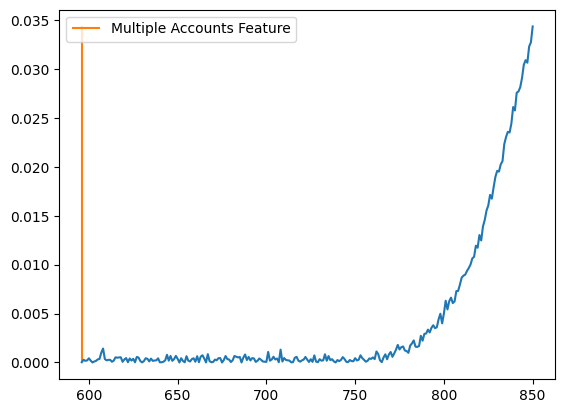

In [121]:
# Lançamento do App - 01/01/2022
# Última coleta de dados sobre o App - 30/04/2024
start = pd.to_datetime("2022-01-01")
end = pd.to_datetime("2024-04-30")

# Adição da feature múltiplas contas ao app
feature_multiple_accounts = round(((max_value + 1) * 0.7))

# Gerando range de dias
min_value = feature_multiple_accounts
max_value = end - start
max_value = max_value.days
lin_range = np.linspace(0, 1, max_value - min_value + 1)

# Gerando pesos
a1 = 1
loc1 = 0.3
scale1 = 0.5
a2 = -1
loc2 = 1.2
scale2 = 0.17


weights = skewnorm.pdf(x=lin_range,
                        a=a2,
                        loc=loc2,
                        scale=scale2)

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.025, size=max_value - min_value + 1))
weights = weights / np.sum(weights)



plt.gca().vlines(np.array([feature_multiple_accounts]), ymin=0, ymax=np.max(weights), colors='C1')
plt.legend(['Multiple Accounts Feature'])
plt.plot(np.arange(min_value, max_value + 1), weights)
plt.show()

In [122]:
accounts['daysFromUserCreation'] = round((pd.to_datetime('2024-04-30') - accounts['userCreatedAt']).dt.days).astype(int)

In [123]:
created_at = rng.choice(
    np.linspace(0, 1, (max_value - min_value + 1)), size=accounts.shape[0], p=weights
)

In [124]:
accounts['createdAt'] = round(created_at * accounts['daysFromUserCreation']).astype(int)

In [125]:
accounts['createdAt'] = pd.to_datetime('2024-04-30') - pd.to_timedelta(accounts['createdAt'], unit='d')

### lastTransferDate

#### first accounts

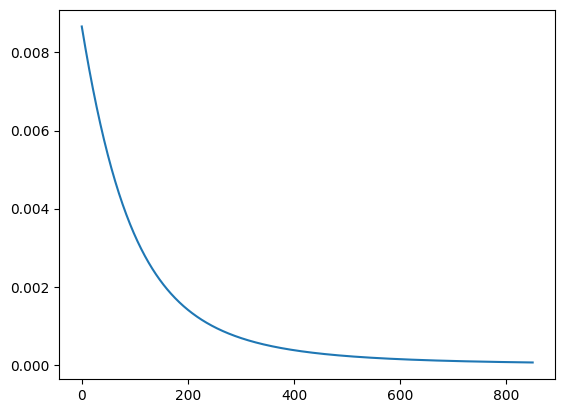

In [126]:
from scipy.stats import alpha

# Gerando range de anos
min_value = 0
max_value = 850
lin_range = np.linspace(0, 1, max_value - min_value + 1)


# Gerando pesos para os anos
a = 3
loc = -0.4
scale = 1
weights = alpha.pdf(x=lin_range, a=a, loc=loc, scale=scale)

# Gerando ruído nos pesos
# weights = np.abs(weights + rng.normal(loc=0, scale=0.05, size=last_day - first_day + 1))
weights = weights / np.sum(weights)

plt.plot(np.arange(min_value, max_value + 1), weights)
plt.show()

In [127]:
first_accounts = accounts.loc[0:USER_COUNT - 1].copy()

In [128]:
first_accounts['daysFromCreation'] = (pd.to_datetime('2024-04-30') - first_accounts['createdAt']).dt.days

In [129]:
last_transfer = rng.choice(
    np.linspace(0, 1, (max_value - min_value + 1)), size=first_accounts.shape[0], p=weights
)

In [130]:
first_accounts['daysFromLastTransfer'] = round(last_transfer * first_accounts['daysFromCreation']).astype(int)

In [131]:
first_accounts['lastTransferDate'] = pd.to_datetime('2024-04-30') - pd.to_timedelta(first_accounts['daysFromLastTransfer'], unit='d')

#### other accounts

In [132]:
from scipy.stats import alpha

# Adição da feature múltiplas contas ao app
feature_multiple_accounts = round(((max_value + 1) * 0.7))

# Gerando range de dias
min_value = feature_multiple_accounts
# Gerando range de anos
min_value = 0
max_value = 850
lin_range = np.linspace(0, 1, max_value - min_value + 1)


# Gerando pesos para os anos
a = 3
loc = -0.4
scale = 1
weights = alpha.pdf(x=lin_range, a=a, loc=loc, scale=scale)

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.05, size=max_value - min_value + 1))
weights = weights / np.sum(weights)

In [133]:
other_accounts = accounts.loc[USER_COUNT:].copy()

In [134]:
other_accounts['daysFromCreation'] = (pd.to_datetime('2024-04-30') - other_accounts['createdAt']).dt.days

In [135]:
last_activity = rng.choice(
    np.linspace(0, 1, (max_value - min_value + 1)), size=other_accounts.shape[0], p=weights
)

In [136]:
other_accounts['daysFromLastTransfer'] = round(last_activity * other_accounts['daysFromUserCreation']).astype(int)

In [137]:
other_accounts['lastTransferDate'] = pd.to_datetime('2024-04-30') - pd.to_timedelta(other_accounts['daysFromLastTransfer'], unit='d')

In [138]:
accounts = pd.concat([first_accounts, other_accounts])

### lastActivityDate

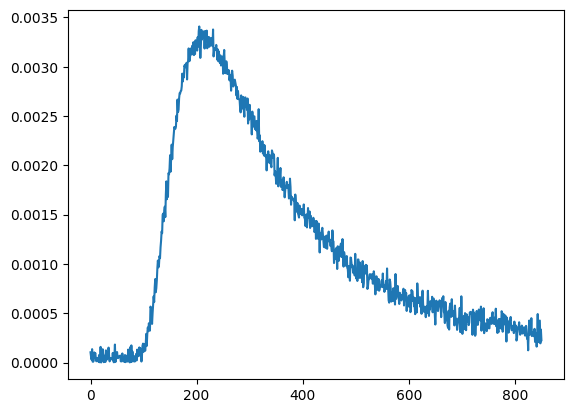

In [139]:
from scipy.stats import alpha

# Gerando range de dias
min_value = feature_multiple_accounts
# Gerando range de anos
min_value = 0
max_value = 850
lin_range = np.linspace(0, 1, max_value - min_value + 1)


# Gerando pesos para os anos
a = 1
loc = 0
scale = 0.5
weights = alpha.pdf(x=lin_range, a=a, loc=loc, scale=scale)

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.05, size=max_value - min_value + 1))
weights = weights / np.sum(weights)

plt.plot(np.arange(min_value, max_value + 1), weights)
plt.show()

In [140]:
accounts['daysFromLastTransfer'] = (pd.to_datetime('2024-04-30') - accounts['lastTransferDate']).dt.days


In [141]:
last_activity = rng.choice(
    np.linspace(0, 1, (max_value - min_value + 1)), size=accounts.shape[0], p=weights
)

In [142]:
accounts['daysFromLastActivity'] = round(last_activity * accounts['daysFromLastTransfer']).astype(int)

In [143]:
accounts['lastActivityDate'] = pd.to_datetime('2024-04-30') - pd.to_timedelta(accounts['daysFromLastActivity'], unit='d')

### balance

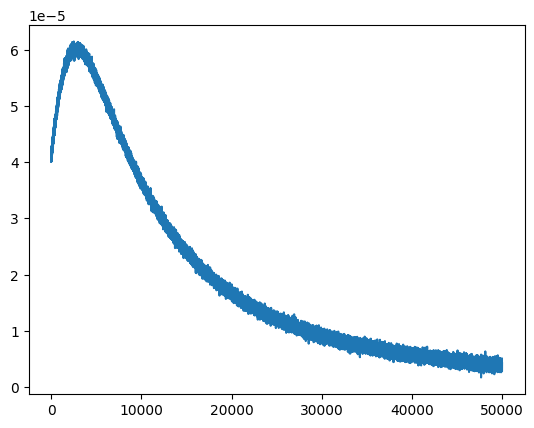

In [144]:
from scipy.stats import alpha

# Gerando range de valores
min_value = 0
max_value = 50000
lin_range = np.linspace(0, 1, max_value - min_value + 1)


# Gerando pesos para os valores
a = 0.01
loc = -0.12
scale = 0.25
weights = alpha.pdf(x=lin_range, a=a, loc=loc, scale=scale)

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.02, size=max_value - min_value + 1))
weights = weights / np.sum(weights)

plt.plot(np.arange(min_value, max_value + 1), weights)
plt.show()

In [145]:
accounts['balance'] = rng.choice(
    np.arange(min_value, max_value + 1), size=accounts.shape[0], p=weights
)
accounts['balance'].describe() 

count    20533.000000
mean     13687.837432
std      11935.414233
min          0.000000
25%       4503.000000
50%       9794.000000
75%      19681.000000
max      49991.000000
Name: balance, dtype: float64

## transfers

### id

In [146]:
transfers['id'] = range(0, TRANSFER_COUNT)
transfers.set_index('id', inplace=True)
transfers.index.name = None

### createdAt

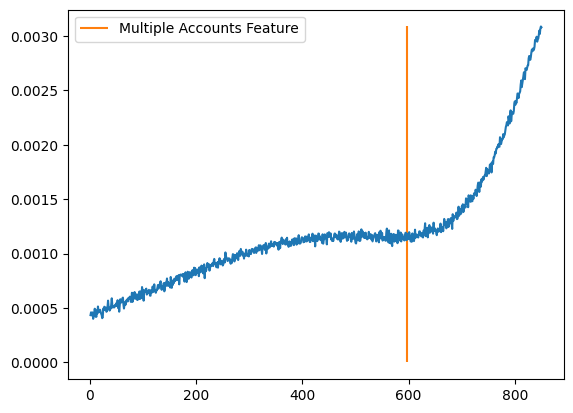

In [147]:
# Lançamento do App - 01/01/2022
# Última coleta de dados sobre o App - 30/04/2024
start = pd.to_datetime("2022-01-01")
end = pd.to_datetime("2024-04-30")

# Gerando range de dias
min_value = 1
max_value = end - start
max_value = max_value.days
lin_range = np.linspace(0, 1, max_value - min_value + 1)

# Gerando pesos
a1 = 1
loc1 = 0.3
scale1 = 0.5
a2 = -1
loc2 = 1.2
scale2 = 0.17

# Gerando as distribuições de pesos
weights1 = skewnorm.pdf(x=lin_range,
                        a=a1,
                        loc=loc1,
                        scale=scale1)
weights2 = skewnorm.pdf(x=lin_range,
                        a=a2,
                        loc=loc2,
                        scale=scale2)
weights = weights1 + weights2

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.025, size=max_value - min_value + 1))
weights = weights / np.sum(weights)

# Adição da feature múltiplas contas ao app
feature_multiple_accounts = round((max_value + 1) * 0.7)

plt.gca().vlines(np.array([feature_multiple_accounts]), ymin=0, ymax=np.max(weights), colors='C1')
plt.legend(['Multiple Accounts Feature'])
plt.plot(np.arange(min_value, max_value + 1), weights)
plt.show()

In [148]:
transfers["createdAt"] = rng.choice(
    np.linspace(1, max_value, max_value - min_value + 1), size=TRANSFER_COUNT, p=weights
)
transfers["createdAt"] = transfers["createdAt"].apply(lambda x: start + timedelta(days=x))

### amount

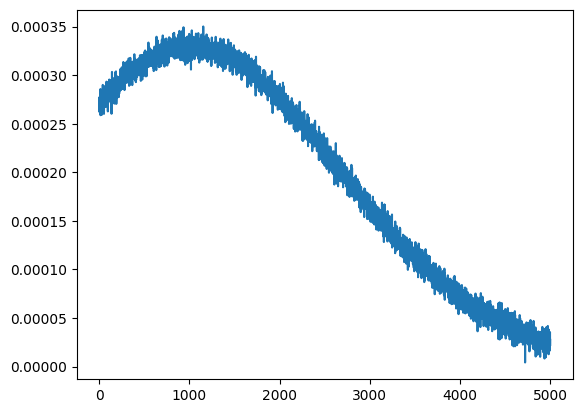

In [149]:
from scipy.stats import alpha

min_value = 0.01
max_value = 5000
lin_range = np.linspace(0, 1, round(max_value - min_value + 1))


# Gerando pesos para os valores
a = 1
loc = 0
scale = 0.4
weights = skewnorm.pdf(x=lin_range, a=a, loc=loc, scale=scale)

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.025, size=round(max_value - min_value + 1)))
weights = weights / np.sum(weights)

plt.plot(np.arange(min_value, max_value + 1), weights)
plt.show()

In [150]:
transfers['amount'] = rng.choice(
    np.arange(min_value, max_value + 1), size=TRANSFER_COUNT
)
transfers['amount'].describe()

count    40000.000000
mean      2502.796525
std       1448.563032
min          0.010000
25%       1238.010000
50%       2514.510000
75%       3761.260000
max       5000.010000
Name: amount, dtype: float64

### isScheduled

In [151]:
scheduled = rng.choice([True, False], size=TRANSFER_COUNT, p=[0.1, 0.9])
transfers['isScheduled'] = scheduled

### status

In [152]:
not_scheduled = transfers[transfers['isScheduled'] == False].copy()
scheduled = transfers[transfers['isScheduled'] == True].copy()

In [153]:
not_scheduled['status'] = 'completed'

scheduled['status'] = rng.choice(['completed', 'canceled', 'failed', 'scheduled'], size=scheduled.shape[0], p=[0.84, 0.04, 0.02, 0.1])

### not scheduled

In [154]:
not_scheduled['date'] = not_scheduled['createdAt']

In [155]:
not_scheduled['daysFromCreation'] = (pd.to_datetime('2024-04-30') - not_scheduled['createdAt']).dt.days
not_scheduled['daysToTransfer'] = 0

### scheduled

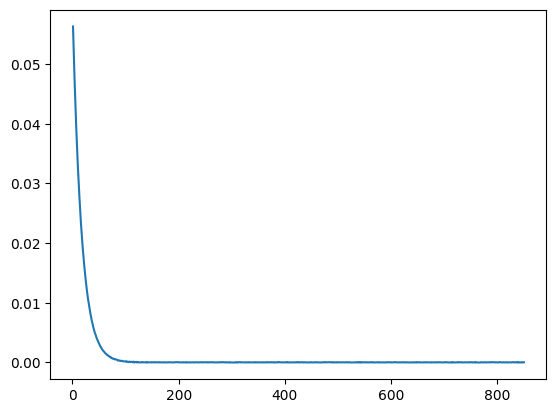

In [156]:
from scipy.stats import expon

# Lançamento do App - 01/01/2022
# Última coleta de dados sobre o App - 30/04/2024
start = pd.to_datetime("2022-01-01")
end = pd.to_datetime("2024-04-30")

# Gerando range de dias
min_value = 1
max_value = end - start
max_value = max_value.days
lin_range = np.linspace(0, 1, max_value - min_value + 1)

# Gerando pesos
a1 = 1
loc1 = 0.3
scale1 = 0.5
a2 = -1
loc2 = 1.2
scale2 = 0.17

# Gerando pesos para os valores
a = 1
loc = 0
scale = 0.02
weights = expon.pdf(x=lin_range, loc=loc, scale=scale)

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.025, size=round(max_value - min_value + 1)))
weights = weights / np.sum(weights)

plt.plot(np.arange(min_value, max_value + 1), weights)
plt.show()

In [157]:
scheduled['daysFromCreation'] = (pd.to_datetime('2024-04-30') - scheduled['createdAt']).dt.days

In [158]:
transfer_date = rng.choice(
    np.linspace(0, 1, (max_value - min_value + 1)), size=scheduled.shape[0], p=weights
)

In [159]:
scheduled['daysToTransfer'] = round(transfer_date * scheduled['daysFromCreation']).astype(int)

In [160]:
scheduled['date'] = scheduled['createdAt'] + pd.to_timedelta(scheduled['daysToTransfer'], unit='d')

In [161]:
transfers = pd.concat([not_scheduled, scheduled])

### fromId toId

In [162]:
transfers['fromId'] = rng.choice(accounts.index, size=TRANSFER_COUNT)
transfers['toId'] = rng.choice(accounts.index, size=TRANSFER_COUNT)

In [163]:
same_account = transfers[transfers['fromId'] == transfers['toId']].copy()
if same_account.shape[0] > 0:
    same_account['toId'] = rng.choice(accounts.index, size=same_account.shape[0])

In [164]:
for index, row in same_account.iterrows():
    transfers.at[index, 'toId'] = rng.choice(accounts.index[accounts.index != row['fromId']])

# Exporting

In [165]:
users.to_csv('users.csv', mode='w', index=False)
accounts.to_csv('accounts.csv', mode='w', index=False)
transfers.to_csv('transfers.csv', mode='w', index=False)